In [1]:
using GrootSim

using CSV
using DataFrames
using DotEnv
DotEnv.load!()
using PyPlot
using SimpleHypergraphs
using Statistics

using PyCall
pickle = pyimport("pickle");

#### Loading the data

In [2]:
datapath = ENV["DATA_PATH"]
basepath = ENV["BASEPATH"]
data_to_include_path = ENV["DATA_TO_INCLUDE_PATH"];

In [3]:
# * loading the data
reddittors_to_include = Set(pickle.load(open(joinpath(data_to_include_path, "final_users_to_include.pkl"))))
subs_to_include = (pickle.load(open(joinpath(data_to_include_path, "final_subs_to_include.pkl"))))
subs_to_include = Set([sub_id[4:end] for sub_id in subs_to_include]);

In [4]:
length(reddittors_to_include), length(subs_to_include)

(54923, 6251)

#### Build the conversational hypergraph

In [5]:
# This hypergraph is built considering all data
# if ignore_NI is true, then this method ignores all comments that have an associated stance labeled with NI, namely Not Inferrable
hg, author_to_id, thread_to_id = create_subreddits_hg(
                            datapath,
                            subs_to_include,
                            reddittors_to_include;
                            ignore_NI=true,
                        );

In [6]:
size(hg)

(43750, 93709)

In [8]:
# (54923, 151176) 
# this size also considers NI comments
size(hg)

(54922, 151176)

#### Vertex degree distribution

In [7]:
# vertex degree distribution
# it counts the number of subthreads a user has contributed
degrees = [length(gethyperedges(hg, v)) for v in 1:nhv(hg)]
quantile!(degrees, [0.5,0.6,0.7,0.8,0.9])

5-element Vector{Float64}:
 2.0
 3.0
 4.0
 5.0
 9.0

In [8]:
maximum(degrees)

1013

In [9]:
sort(degrees, rev=true)[1:15]

15-element Vector{Int64}:
 1013
  706
  645
  583
  535
  511
  481
  435
  420
  402
  389
  356
  345
  342
  336

In [10]:
degree_dist = degree_histogram(hg; normalized=true) 
degree_dist

Dict{Int64, Union{Float64, Int64}} with 199 entries:
  56  => 0.000297143
  35  => 0.000571429
  60  => 0.000137143
  308 => 2.28571e-5
  67  => 0.000205714
  73  => 0.000137143
  251 => 2.28571e-5
  115 => 2.28571e-5
  112 => 6.85714e-5
  420 => 2.28571e-5
  86  => 0.000114286
  168 => 2.28571e-5
  207 => 2.28571e-5
  12  => 0.00747429
  75  => 4.57143e-5
  23  => 0.00166857
  111 => 4.57143e-5
  264 => 2.28571e-5
  41  => 0.000548571
  ⋮   => ⋮

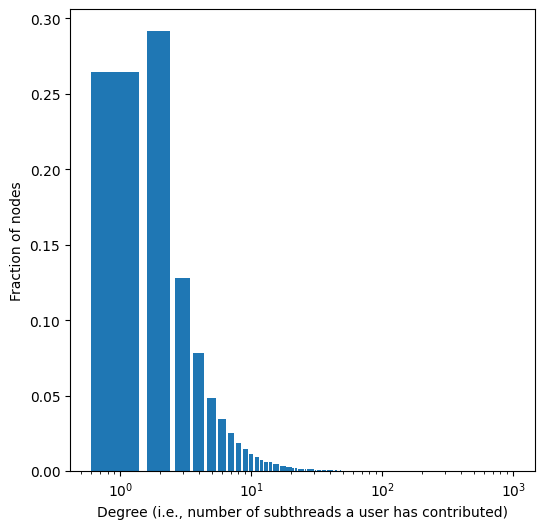

In [ ]:
clf()

figure(figsize=(6, 6))

bar(collect(keys(degree_dist)), collect(values(degree_dist)))
xlabel("Degree (i.e., number of subthreads a user has contributed)")
ylabel("Fraction of nodes")

xscale("log")

gcf()

In [14]:
# get the author with the largest number of comments
# here, we need author data
v_deg = [(v, length(gethyperedges(hg, v))) for v in 1:nhv(hg)]
sort!(v_deg, by=x->x[2], rev=true)
get_vertex_meta(hg, v_deg[1][1])

:t2_4fzfl

#### Hyperedge size distribution

In [15]:
# it counts the number of users in a subthread
sizes = [length(getvertices(hg, he)) for he in 1:nhe(hg)]
quantile!(sizes, [0.5,0.6,0.7,0.8,0.9])

5-element Vector{Float64}:
 2.0
 2.0
 2.0
 2.0
 3.0

In [16]:
sort(sizes, rev=true)[1:15]

15-element Vector{Int64}:
 326
 270
 243
 179
 179
 168
 166
 157
 151
 147
 142
 136
 132
 128
 126

In [17]:
size_dist = size_histogram(hg; normalized=true) 
size_dist

Dict{Int64, Union{Float64, Int64}} with 114 entries:
  5   => 0.0157616
  56  => 3.2014e-5
  55  => 6.4028e-5
  114 => 2.13427e-5
  35  => 9.6042e-5
  60  => 3.2014e-5
  30  => 0.000170741
  32  => 0.000138727
  6   => 0.00928406
  136 => 1.06713e-5
  45  => 8.53707e-5
  67  => 1.06713e-5
  73  => 1.06713e-5
  64  => 3.2014e-5
  151 => 1.06713e-5
  4   => 0.0335613
  13  => 0.0012272
  63  => 4.26853e-5
  54  => 3.2014e-5
  ⋮   => ⋮

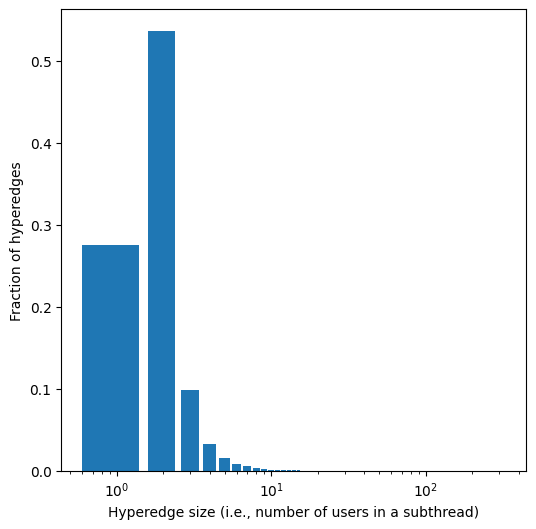

In [18]:
clf()

figure(figsize=(6, 6)) 

bar(collect(keys(size_dist)), collect(values(size_dist)))
xlabel("Hyperedge size (i.e., number of users in a subthread)")
ylabel("Fraction of hyperedges")

xscale("log")

gcf()

In [19]:
# get the hyperedges with the largest number of users
he_size = [(he, length(getvertices(hg, he))) for he in 1:nhe(hg)]
sort!(he_size, by=x->x[2], rev=true)
get_hyperedge_meta(hg, he_size[1][1])

:t3_vo98nu

#### Other stats

In [20]:
cc = get_connected_components(hg)

2303-element Vector{Vector{Int64}}:
 [1, 2, 3, 361, 257, 43, 258, 12, 123, 124  …  27099, 27238, 9037, 11, 13, 14, 1132, 2653, 2913, 3005]
 [102]
 [103]
 [206]
 [248, 256]
 [313, 314]
 [326, 327]
 [393, 394]
 [402, 403]
 [459]
 ⋮
 [43583, 43584]
 [43585]
 [43586, 43587]
 [43653]
 [43655]
 [43709]
 [43710]
 [43736]
 [43745, 43746]

In [ ]:
# cflp = CFLabelPropagationFinder(100, 1234)
# comms = findcommunities(hg, cflp)